# Qubit Tune-up with SHF Instruments

In this notebook we demonstrate qubit tuneup with the LabOne Q software, implemented as a sequence of experiments. 

Before starting the experiments, we define a set of initial qubit parameters, as might be known from fabrication. 

These parameters can then be used to update the baseline calibration used in the experiments.

## 0. General Imports and Definitions
### 0.1 Python Imports 

In [151]:
# LabOne Q:
from laboneq.simple import *

# plotting and fitting functionality
from laboneq.analysis.fitting import (
    lorentzian,
    oscillatory,
    oscillatory_decay,
    exponential_decay,
)
from laboneq.contrib.example_helpers.plotting.plot_helpers import plot_simulation

# descriptor imports
from laboneq.contrib.example_helpers.descriptors.shfsg_shfqa_pqsc import (
    descriptor_shfsg_shfqa_pqsc,
)

# for saving results and pulse sheets
from pathlib import Path
import time

import matplotlib.pyplot as plt
import numpy as np

### 0.2 Function Definitions

In [152]:
# define sweep parameter
def create_readout_freq_sweep(qubit, start_freq, stop_freq, num_points):
    return LinearSweepParameter(
        uid=f"res_freq_{qubit.uid}",
        start=start_freq + qubit.parameters.readout_resonator_frequency - qubit.parameters.readout_lo_frequency,
        stop=stop_freq + qubit.parameters.readout_resonator_frequency - qubit.parameters.readout_lo_frequency,
        count=num_points,
    )

# function that returns the calibration of the readout line oscillator for spectroscopy
def res_spec_calib(frequency_sweep, amplitude_sweep=None):
    exp_calibration = Calibration()
    # sets the oscillator of the experimental measure signal
    exp_calibration["measure"] = SignalCalibration(
        # for spectroscopy, use the hardware oscillator of the QA, and set the sweep parameter as frequency
        oscillator=Oscillator(
            "readout_osc",
            frequency=frequency_sweep,
            modulation_type=ModulationType.HARDWARE,
        ),
        amplitude=amplitude_sweep,
    )
    return exp_calibration


# signal maps for the qubit readout only
def res_spec_map(qubit):
    signal_map = {
        "measure": device_setup.logical_signal_groups[qubit.uid].logical_signals[
            "measure_line"
        ],
        "acquire": device_setup.logical_signal_groups[qubit.uid].logical_signals[
            "acquire_line"
        ],
    }
    return signal_map

# create gaussian square pulse for readout
def create_readout_pulse(
    qubit, sigma=0.2
):
    readout_pulse = pulse_library.gaussian_square(
        uid=f"readout_pulse_{qubit.uid}",
        length=qubit.parameters.user_defined['readout_len'],
        amplitude=qubit.parameters.user_defined['readout_amp'],
        width=qubit.parameters.user_defined['readout_len'] * 0.9,
        sigma=sigma,
    )
    return readout_pulse

# qubit spectroscopy freq sweep
def create_drive_freq_sweep(qubit, start_freq, stop_freq, num_points):
    return LinearSweepParameter(
        uid=f"drive_freq_{qubit.uid}",
        start=start_freq + qubit.parameters.resonance_frequency_ge - qubit.parameters.drive_lo_frequency,
        stop=stop_freq + qubit.parameters.resonance_frequency_ge - qubit.parameters.drive_lo_frequency,
        count=num_points,
    )

# define square pulse for qubit spec
def create_drive_spec_pulse(qubit, amp = 0.95):
    pulse = pulse_library.const(
        uid=f"drive_spec_pulse_{qubit.uid}",
        length=qubit.parameters.user_defined["pulse_length"],
        amplitude=amp, #max power to start
    )
    return pulse

# signal map for qubit drive and readout
def signal_map_default(qubit):
    signal_map = {
        "drive": device_setup.logical_signal_groups[f"{qubit.uid}"].logical_signals[
            "drive_line"
        ],
        "measure": device_setup.logical_signal_groups[f"{qubit.uid}"].logical_signals[
            "measure_line"
        ],
        "acquire": device_setup.logical_signal_groups[f"{qubit.uid}"].logical_signals[
            "acquire_line"
        ],
    }
    return signal_map

#define gaussian pulse for qubit drive
def create_rabi_drive_pulse(qubit):
    return pulse_library.gaussian(
        uid=f"gaussian_drive_{qubit.uid}",
        length=qubit.parameters.user_defined["pulse_length"],
        amplitude=1,
    )

# define qubit drive rabi sweep
def create_rabi_amp_sweep(qubit, amp_num, uid="rabi_amp"):
    amp_min = 0.1
    amp_max = min([qubit.parameters.user_defined['amplitude_pi'] * 2.2, 1.0])
    return LinearSweepParameter(uid=uid, start=amp_min, stop=amp_max, count=amp_num)

# define delay time sweep for Ramsey, T1, echo
def create_delay_sweep(
    start=0, stop=50e-6, count=100, axis_name="Time [s]"
):
    time_sweep = LinearSweepParameter(
        uid="time_sweep_param", start=start, stop=stop, count=count, axis_name=axis_name
    )
    return time_sweep

# define ramsey drive pulse
def create_ramsey_drive_pulse(qubit):
    return pulse_library.gaussian(
        uid=f"gaussian_drive_{qubit.uid}",
        length=qubit.parameters.user_defined['pulse_length'],
        amplitude=qubit.parameters.user_defined['amplitude_pi'] / 2,
    )

# define T1 drive pulse
def create_T1_drive_pulse(qubit):
    return pulse_library.gaussian(
        uid=f"gaussian_drive_{qubit.uid}",
        length=qubit.parameters.user_defined['pulse_length'],
        amplitude=qubit.parameters.user_defined['amplitude_pi'],
    )

def create_pi_2_pulse(qubit):
    return pulse_library.gaussian(
        uid=f"gaussian_pi_2_drive_{qubit.uid}",
        length=qubit.parameters.user_defined['pulse_length'],
        amplitude=qubit.parameters.user_defined['amplitude_pi']/2,
    )

def create_pi_pulse(qubit):
    return pulse_library.gaussian(
        uid=f"gaussian_pi_drive_{qubit.uid}",
        length=qubit.parameters.user_defined['pulse_length'],
        amplitude=qubit.parameters.user_defined['amplitude_pi'],
    )

## 1. Define the Instrument Setup and Required Experimental Parameters
### 1.1 Create device setup

Create the device setup from the descriptor, and apply some convenient mapping to instruments and logical signals.

In [153]:
descriptor_shfqc = """
instruments:
  SHFQC:
  - address: DEV12237
    uid: device_shfqc
    interface: 1gbe

connections:
  device_shfqc:
    - iq_signal: q0/drive_line
      ports: SGCHANNELS/0/OUTPUT

    - iq_signal: q0/measure_line
      ports: [QACHANNELS/0/OUTPUT]
    - acquire_signal: q0/acquire_line
      ports: [QACHANNELS/0/INPUT]

    - iq_signal: q1/drive_line
      ports: SGCHANNELS/2/OUTPUT

    - iq_signal: q1/measure_line
      ports: [QACHANNELS/0/OUTPUT]
    - acquire_signal: q1/acquire_line
      ports: [QACHANNELS/0/INPUT]
"""

In [154]:
# Define and Load our Device Setup
device_setup = DeviceSetup.from_descriptor(
    yaml_text=descriptor_shfqc,
    server_host="localhost",  # ip address of the LabOne dataserver used to communicate with the instruments
    server_port="8004",  # port number of the dataserver - default is 8004
    setup_name="my_setup",  # setup name
)

# define shortcut to logical signals for convenience
lsg = {
    qubit_name: device_setup.logical_signal_groups[qubit_name].logical_signals
    for qubit_name in device_setup.logical_signal_groups.keys()
}

### 1.2 Qubit Parameters

A python dictionary containing all parameters needed to control and readout the qubits - frequencies, pulse lengths, timings

May initially contain only the design parameters and will be updated with measurement results during the tuneup procedure

In [155]:
q0 = Transmon.from_logical_signal_group(
    "q0",
    lsg=device_setup.logical_signal_groups["q0"],
    parameters=TransmonParameters(
        resonance_frequency_ge=3.15e9,     #Drive frequency for qubit ge transition
        resonance_frequency_ef=2.95e9,     #Drive frequency for qubit ef transtion
        drive_lo_frequency=6.5e9,          #Center frequency for qubit drive, needs to be within 500 MHz of both ge and ef frequencies
        readout_resonator_frequency=6.040e9, #Readout frequency for readout resonator
        readout_lo_frequency=6.5e9,        #Center frequency for readout line, shared node, all qubits need to have the same value
        readout_integration_delay=60e-9,       #Propogation delay for readout aqcuire line, relative to default 212 ns, shared node, all qubits need to have the same value
        drive_range = 10,                  #Output range for qubit drive in dBm
        readout_range_out = -0,             #Output range for readout resonator in dBm, shared node, all qubits need to have the same value
        readout_range_in = -15,              #Input range for readout resonator in dBm, shared node, all qubits need to have the same value
        
        user_defined={                     #Pulse Parameters to be included as user_defined
            "amplitude_pi": 0.99,           #Amplitude of Pi pulse, linear gain from 0 to 1 of drive_range
            "pulse_length": 50e-9,         #Length of drive/Pi pulse
            "readout_len": 2e-6,           #Length of readout pulse
            "readout_amp": 0.98,           #Amplitude of readout pulse, linear gain from 0 to 1 of readout_range_out, starts at 1 for spectroscopy
            "reset_length": 5e-6,          #Relaxation time to return to ground state
        },
    ),
)

q1 = Transmon.from_logical_signal_group(
    "q1",
    lsg=device_setup.logical_signal_groups["q1"],
    parameters=TransmonParameters(
        resonance_frequency_ge=6.25e9,
        resonance_frequency_ef=5.95e9,
        drive_lo_frequency=7.1e9,
        readout_resonator_frequency=7.4e9,
        readout_lo_frequency=q0.parameters.readout_lo_frequency, #Shared node, needs to match q0 center frequency
        readout_integration_delay=q0.parameters.readout_integration_delay, #Shared node, needs to match q0
        drive_range = 10,
        readout_range_out = q0.parameters.readout_range_out, #Shared node, needs to match q0
        readout_range_in = q0.parameters.readout_range_in, #Shared node, needs to match q0
        user_defined={
            "amplitude_pi": 0.6,
            "pulse_length": 50e-9,
            "readout_len": 2e-6,
            "readout_amp": 0.98,
            "reset_length": 5e-6,
        },
    ),
)

In [156]:
#Finish calibrating SHFQC with qubit parameters
qubits = [q0, q1]
for qubit in qubits:
    device_setup.set_calibration(qubit.calibration())

#Choose which qubit will be measured
measure_q = q0

### 2.2 Create and Connect to a QCCS Session 

Establishes the connection to the instruments and readies them for experiments

In [157]:
# perform experiments in emulation mode or on hardware - if True, also generate dummy data for fitting
emulate = False

# create and connect to a session
session = Session(device_setup=device_setup)
session.connect(do_emulation=emulate)

[2024.07.11 10:55:03.967] INFO    Logging initialized from [Default inline config in laboneq.laboneq_logging] logdir is Z:\projects\2024-fluxonium\measurement\coupler_20240702\LabOneQ\laboneq_output\log
[2024.07.11 10:55:03.970] INFO    VERSION: laboneq 2.32.0
[2024.07.11 10:55:03.971] INFO    Connecting to data server at localhost:8004
[2024.07.11 10:55:03.977] INFO    Connected to Zurich Instruments LabOne Data Server version 24.04 at localhost:8004
[2024.07.11 10:55:04.034] WARNING SHFQC/QA:dev12237: Include the device options 'SHFQC/PLUS/QC6CH' in the device setup ('options' field of the 'instruments' list in the device setup descriptor). This will become a strict requirement in the future.
[2024.07.11 10:55:04.740] INFO    Configuring the device setup
[2024.07.11 10:55:04.849] INFO    The device setup is configured


## 3. Qubit Tuneup - Experimental Sequence

Sequence of experiments for tuneup from scratch of a superconducting qubit in circuit QED architecture 

### 3.1 Resonator Spectroscopy: CW

Find the resonance frequency of the qubit readout resonator by looking at the transmission or reflection of a probe signal applied through the readout line

#### 3.1.1 Additional Experimental Parameters

Define the frequency scan

#### 3.1.2 Experiment Definition

Define the experimental pulse and readout sequence - here without any explicit qubit reference

Explicit qubit reference is then given through different experimental calibration and signal maps

In [158]:
# function that defines a resonator spectroscopy experiment, and takes the frequency sweep as a parameter
def res_spectroscopy_CW(freq_sweep, exp_settings):
    # Create resonator spectroscopy experiment - uses only readout drive and signal acquisition
    exp_spec = Experiment(
        uid="Resonator Spectroscopy",
        signals=[
            ExperimentSignal("measure"),
            ExperimentSignal("acquire"),
        ],
    )

    ## define experimental sequence
    # loop - average multiple measurements for each frequency - measurement in spectroscopy mode
    with exp_spec.acquire_loop_rt(
        uid="shots",
        count=exp_settings["num_averages"],
        acquisition_type=AcquisitionType.SPECTROSCOPY,
    ):
        with exp_spec.sweep(uid="res_freq", parameter=freq_sweep):
            # readout pulse and data acquisition
            with exp_spec.section(uid="spectroscopy"):
                # resonator signal readout
                exp_spec.acquire(
                    signal="acquire",
                    handle="res_spec",
                    length=exp_settings["integration_time"],
                )
            with exp_spec.section(uid="delay", length=1e-6):
                # holdoff time after signal acquisition
                exp_spec.reserve(signal="measure")

    return exp_spec

#### 3.1.3 Run and Evaluate Experiment
Runs the experiment and evaluates the data returned by the measurement

In [159]:
measure_q.parameters.readout_range_out = -10
measure_q.parameters.readout_range_in = -10
measure_q.parameters.user_defined['readout_amp'] = 0.9

In [160]:
print(measure_q)

Transmon(
│   uid='q0',
│   signals={'drive': '/logical_signal_groups/q0/drive_line', 'measure': '/logical_signal_groups/q0/measure_line', 'acquire': '/logical_signal_groups/q0/acquire_line'},
│   parameters=TransmonParameters(
│   │   resonance_frequency_ge=3150000000.0,
│   │   resonance_frequency_ef=2950000000.0,
│   │   drive_lo_frequency=6500000000.0,
│   │   readout_resonator_frequency=6040000000.0,
│   │   readout_lo_frequency=6500000000.0,
│   │   readout_integration_delay=6e-08,
│   │   drive_range=10,
│   │   readout_range_out=-10,
│   │   readout_range_in=-10,
│   │   flux_offset_voltage=0,
│   │   user_defined={
│   │   │   'amplitude_pi': 0.99,
│   │   │   'pulse_length': 5e-08,
│   │   │   'readout_len': 2e-06,
│   │   │   'readout_amp': 0.9,
│   │   │   'reset_length': 5e-06
│   │   }
│   )
)

In [161]:
device_setup.set_calibration(measure_q.calibration())

In [64]:
# measure_q.parameters.readout_lo_frequency
measure_q.parameters.readout_resonator_frequency = 7.133e9

In [65]:
measure_q.parameters.readout_resonator_frequency

7133000000.0

In [66]:
# frequency range of spectroscopy scan - around expected resonator frequency as defined in qubit parameters
start_freq = -50e6
stop_freq = 50e6
num_points = 1001
integration_time = 2e-3
num_averages = 1

In [67]:
res = (stop_freq + (-start_freq))/(num_points*1e6)
print(f'resolution = {res} MHz')

resolution = 0.0999000999000999 MHz


In [68]:
# define the experiment with the frequency sweep relevant for qubit 0
freq_sweep = create_readout_freq_sweep(measure_q, start_freq, stop_freq, num_points)
exp_settings = {"integration_time": integration_time, "num_averages": num_averages}
exp_spec = res_spectroscopy_CW(freq_sweep, exp_settings)

# set signal calibration and signal map for experiment
exp_spec.set_calibration(res_spec_calib(freq_sweep))

In [69]:
exp_spec.set_signal_map(res_spec_map(measure_q))

# run the experiment on the open instrument session
compiled_res_spec = session.compile(exp_spec)
res_spec_results = session.run()

# save the data
timestamp = time.strftime("%Y%m%dT%H%M%S")
Path("Results_Needed").mkdir(parents=True, exist_ok=True)
session.save_results(f"Results_Needed/res_spec_results_{timestamp}.json")
print(f"File saved as Results_Needed/res_spec_results_{timestamp}.json")

[2024.07.09 10:00:22.877] INFO    Starting LabOne Q Compiler run...
[2024.07.09 10:00:22.946] INFO    Schedule completed. [0.066 s]
[2024.07.09 10:00:23.053] INFO    Code generation completed for all AWGs. [0.106 s]
[2024.07.09 10:00:23.055] INFO    Completed compilation step 1 of 1. [0.175 s]
[2024.07.09 10:00:23.068] INFO     ────────────────────────────────────────────────────────────────── 
[2024.07.09 10:00:23.069] INFO      Device         AWG   SeqC LOC   CT entries   Waveforms   Samples  
[2024.07.09 10:00:23.071] INFO     ────────────────────────────────────────────────────────────────── 
[2024.07.09 10:00:23.072] INFO      device_shfqc     0         25            0           0         0  
[2024.07.09 10:00:23.073] INFO     ────────────────────────────────────────────────────────────────── 
[2024.07.09 10:00:23.075] INFO      TOTAL                      25            0                     0  
[2024.07.09 10:00:23.077] INFO     ────────────────────────────────────────────────────

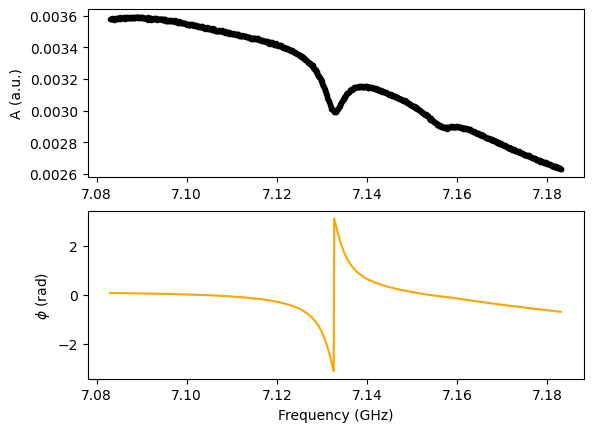

In [70]:
electrical_delay = 56.25e-9
# electrical_delay = 1
# _delay = 10e9

# get the measurement data returned by the instruments from the QCCS session
spec_res = res_spec_results.get_data("res_spec")
# define the frequency axis from the qubit parameters
spec_freq = measure_q.parameters.readout_lo_frequency + res_spec_results.get_axis("res_spec")[0]
# %matplotlib qt
if emulate:
    # create some dummy data if running in emulation mode
    spec_res = lorentzian(
        spec_freq,
        10e6,
        measure_q.parameters.readout_frequency * (0.995 + 0.01 * np.random.rand(1)[0])
        + measure_q.parameters.readout_lo_frequency,
        -1e7,
        10,
    ) + 0.2 * np.random.rand(len(spec_freq))

# plot the measurement data
fig, [ax1, ax2] = plt.subplots(2, 1)
ax1.plot(spec_freq / 1e9, abs(spec_res), ".k")
ax2.plot(spec_freq / 1e9, np.angle(np.exp(1j*electrical_delay*2*np.pi*spec_freq)*spec_res), "orange")
# _phase = _delay*spec_freq*np.angle(spec_res)
# ax2.plot(spec_freq / 1e9, _phase, "orange")
ax1.set_ylabel("A (a.u.)")
ax2.set_ylabel("$\\phi$ (rad)")
ax2.set_xlabel("Frequency (GHz)")
# ax2.axvline(6582311900.0/1e9)

plt.show()

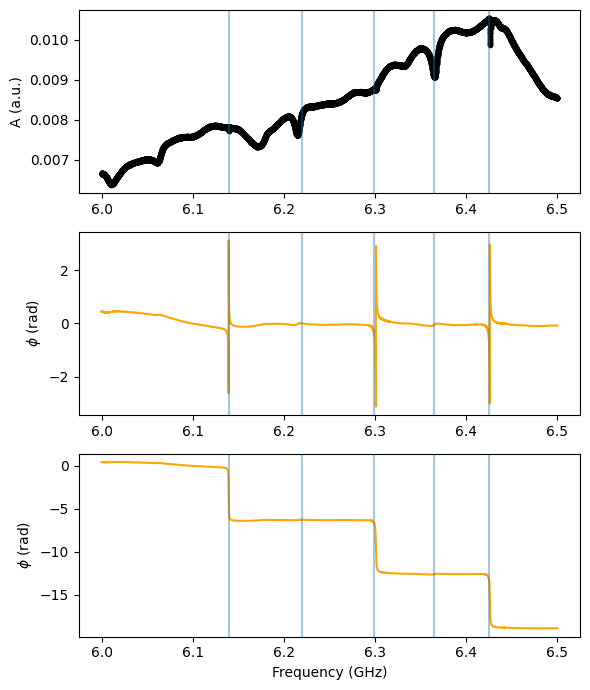

In [60]:
vl = []

electrical_delay = 56.25e-9
# electrical_delay = 1
# _delay = 10e9

# get the measurement data returned by the instruments from the QCCS session
spec_res = res_spec_results.get_data("res_spec")
# define the frequency axis from the qubit parameters
spec_freq = measure_q.parameters.readout_lo_frequency + res_spec_results.get_axis("res_spec")[0]
# %matplotlib qt
if emulate:
    # create some dummy data if running in emulation mode
    spec_res = lorentzian(
        spec_freq,
        10e6,
        measure_q.parameters.readout_frequency * (0.995 + 0.01 * np.random.rand(1)[0])
        + measure_q.parameters.readout_lo_frequency,
        -1e7,
        10,
    ) + 0.2 * np.random.rand(len(spec_freq))

# plot the measurement data
fig, [ax1, ax2, ax3] = plt.subplots(3, 1, figsize=(6, 7))
ax1.plot(spec_freq / 1e9, abs(spec_res), ".k")

ax2.plot(spec_freq / 1e9, np.angle(np.exp(1j*electrical_delay*2*np.pi*spec_freq)*spec_res), "orange")
ax3.plot(spec_freq / 1e9, np.unwrap(np.angle(np.exp(1j*electrical_delay*2*np.pi*spec_freq)*spec_res)), "orange")

ax1.set_ylabel("A (a.u.)")
# ax1.set_title('Mag')

ax2.set_ylabel("$\\phi$ (rad)")
# ax2.set_title('Wrapped phase')

ax3.set_ylabel("$\\phi$ (rad)")
# ax3.set_title('Unwrapped phase')
ax3.set_xlabel("Frequency (GHz)")

vl = [6.14, 6.22, 6.299, 6.365, 6.425]
a = 0.4
for _vl in vl:
    ax1.axvline(_vl, ls='-', color='tab:blue', alpha=a)
    ax2.axvline(_vl, ls='-', color='tab:blue', alpha=a)
    ax3.axvline(_vl, ls='-', color='tab:blue', alpha=a)

plt.tight_layout()

In [437]:
measure_q.parameters.readout_resonator_frequency = 6.8226e9
measure_q.parameters.readout_range_out = -30
measure_q.parameters.readout_range_in = -15
measure_q.parameters.user_defined['readout_amp'] = 0.04
electrical_delay = 65.1e-9

device_setup.set_calibration(
    measure_q.calibration()
)

## Resonator vs flux 

### resonator spectroscopy setup

In [480]:
# frequency range of spectroscopy scan -
# around expected resonator frequency as defined in qubit parameters
start_freq = -10e6
stop_freq = 15e6
num_points = 201

# define number of averages
# used for 2^num_averages, maximum: num_averages = 17
num_averages = 12

readout_pulse = create_readout_pulse(measure_q)

In [481]:
2**12

4096

In [482]:
print(measure_q)

Transmon(
│   uid='q0',
│   signals={'drive': '/logical_signal_groups/q0/drive_line', 'measure': '/logical_signal_groups/q0/measure_line', 'acquire': '/logical_signal_groups/q0/acquire_line'},
│   parameters=TransmonParameters(
│   │   resonance_frequency_ge=3150000000.0,
│   │   resonance_frequency_ef=2950000000.0,
│   │   drive_lo_frequency=6500000000.0,
│   │   readout_resonator_frequency=6822600000.0,
│   │   readout_lo_frequency=6500000000.0,
│   │   readout_integration_delay=6e-08,
│   │   drive_range=10,
│   │   readout_range_out=-30,
│   │   readout_range_in=-15,
│   │   flux_offset_voltage=0,
│   │   user_defined={
│   │   │   'amplitude_pi': 0.99,
│   │   │   'pulse_length': 5e-08,
│   │   │   'readout_len': 2e-06,
│   │   │   'readout_amp': 0.04,
│   │   │   'reset_length': 5e-06,
│   │   │   'readout_range_out': -30,
│   │   │   'readout_range_in': -15
│   │   }
│   )
)

In [483]:
# measure_q.parameters.user_defined['readout_amp'] = 0.1
# measure_q.parameters.readout_range_out = -30
# measure_q.parameters.readout_range_in = -15
# device_setup.set_calibration(
#     measure_q.calibration()
# )

#### 3.2.2 Experiment Definition

In [484]:
# function that defines a resonator spectroscopy experiment, and takes the frequency sweep as a parameter

def res_spectroscopy_pulsed(freq_sweep, num_averages, readout_pulse):
    # Create resonator spectroscopy experiment - uses only readout drive and signal acquisition
    exp_spec_pulsed = Experiment(
        uid="Resonator Spectroscopy",
        signals=[
            ExperimentSignal("measure"),
            ExperimentSignal("acquire"),
        ],
    )

    ## define experimental sequence
    # outer loop - vary drive frequency

    # inner loop - average multiple measurements for each frequency - measurement in spectroscopy mode
    with exp_spec_pulsed.acquire_loop_rt(
        uid="shots",
        count=2**num_averages,
        acquisition_type=AcquisitionType.SPECTROSCOPY,
        averaging_mode=AveragingMode.SEQUENTIAL,
    ):
        with exp_spec_pulsed.sweep(
            uid="res_freq",
            parameter=freq_sweep,
            chunk_count=1,
        ):
            # readout pulse and data acquisition
            with exp_spec_pulsed.section(uid="spectroscopy"):
                # play resonator excitation pulse
                exp_spec_pulsed.play(signal="measure", pulse=readout_pulse)
                # resonator signal readout
                exp_spec_pulsed.acquire(
                    signal="acquire", handle="res_spec_pulsed", length=readout_pulse.length
                )
            with exp_spec_pulsed.section(uid="delay", length=10e-6):
                # holdoff time after signal acquisition - minimum 1us required for data processing on UHFQA
                exp_spec_pulsed.reserve(signal="measure")

    return exp_spec_pulsed

#### 3.2.3 Apply Experiment Parameters and Compile

In [485]:
# measure_q.parameters.readout_range_out = 5

# # apply calibration to device setup
device_setup.set_calibration(
    measure_q.calibration()
)

In [486]:
# create freq sweep
freq_sweep = create_readout_freq_sweep(measure_q, start_freq, stop_freq, num_points)

# define the experiment with the frequency sweep relevant for qubit
exp_spec_pulsed = res_spectroscopy_pulsed(freq_sweep, num_averages, readout_pulse)

# set signal calibration and signal map for experiment to qubit
exp_spec_pulsed.set_calibration(res_spec_calib(freq_sweep))
exp_spec_pulsed.set_signal_map(res_spec_map(measure_q))

In [487]:
# compile the experiment on the open instrument session
compiled_spec_pulsed = session.compile(exp_spec_pulsed)

Path("Pulse_Sheets").mkdir(parents=True, exist_ok=True)

# generate a pulse sheet to inspect experiment before runtime
show_pulse_sheet("Pulse_Sheets/Pulsed_Spectroscopy", compiled_spec_pulsed)

[2024.07.09 21:58:25.870] INFO    Starting LabOne Q Compiler run...
[2024.07.09 21:58:25.929] INFO    Schedule completed. [0.056 s]
[2024.07.09 21:58:26.134] INFO    Code generation completed for all AWGs. [0.199 s]
[2024.07.09 21:58:26.138] INFO    Completed compilation step 1 of 1. [0.264 s]
[2024.07.09 21:58:26.148] INFO     ────────────────────────────────────────────────────────────────── 
[2024.07.09 21:58:26.153] INFO      Device         AWG   SeqC LOC   CT entries   Waveforms   Samples  
[2024.07.09 21:58:26.157] INFO     ────────────────────────────────────────────────────────────────── 
[2024.07.09 21:58:26.160] INFO      device_shfqc     0         23            0           1      8000  
[2024.07.09 21:58:26.162] INFO     ────────────────────────────────────────────────────────────────── 
[2024.07.09 21:58:26.165] INFO      TOTAL                      23            0                  8000  
[2024.07.09 21:58:26.169] INFO     ────────────────────────────────────────────────────

Z:\projects\2024-fluxonium\measurement\coupler_20240702\LabOneQ\Pulse_Sheets\Pulsed_Spectroscopy_2024-07-09-21-58-26.html

#### 3.2.4 Run and Evaluate Experiment

In [488]:
# run the experiment on the open instrument session
spec_pulsed_results = session.run()

# save the data
timestamp = time.strftime("%Y%m%dT%H%M%S")
Path("Results_Needed").mkdir(parents=True, exist_ok=True)
session.save_results(f"Results_Needed/spec_pulsed_results_{timestamp}.json")
print(f"File saved as Results_Needed/spec_pulsed_results_{timestamp}.json")

[2024.07.09 21:58:26.593] INFO    Configuring the device setup
[2024.07.09 21:58:26.708] INFO    The device setup is configured
[2024.07.09 21:58:27.883] INFO    Starting near-time execution...
[2024.07.09 21:58:28.326] INFO    Estimated RT execution time: 9.88 s.
[2024.07.09 21:58:38.539] INFO    Finished near-time execution.
File saved as Results_Needed/spec_pulsed_results_20240709T215838.json


In [489]:
# electrical_delay = 65.0e-9

Text(0.5, 0, 'Frequency (GHz)')

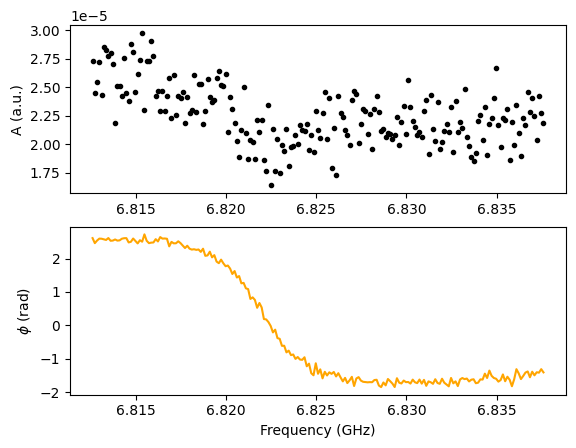

In [490]:
# get the measurement data returned by the instruments from the QCCS session
spec_res = spec_pulsed_results.get_data("res_spec_pulsed")
# define the frequency axis from the qubit parameters
spec_freq = (
    measure_q.parameters.readout_lo_frequency + spec_pulsed_results.get_axis("res_spec_pulsed")[0]
)

if emulate:
    # create some dummy data if running in emulation mode
    spec_res = lorentzian(
        spec_freq,
        10e6,
        measure_q.parameters.readout_resonator_frequency * (0.995 + 0.01 * np.random.rand(1)[0]),
        -2e6,
        1,
    ) + 0.1 * np.random.rand(len(spec_freq))

# plot the measurement data
fig, [ax1, ax2] = plt.subplots(2, 1)
ax1.plot(spec_freq / 1e9, abs(spec_res), ".k")
ax2.plot(spec_freq / 1e9, np.angle(np.exp(1j*electrical_delay*2*np.pi*spec_freq)*spec_res), "orange")
ax1.set_ylabel("A (a.u.)")
ax2.set_ylabel("$\\phi$ (rad)")
ax2.set_xlabel("Frequency (GHz)")
# ax2.axvline(spec_freq[np.argmin(np.angle(np.exp(1j*electrical_delay*2*np.pi*spec_freq)*spec_res))]/1e9)
# spec_freq[np.argmin(abs(spec_res))]/1e9

In [491]:
measure_q?

Transmon(
│   uid='q0',
│   signals={'drive': '/logical_signal_groups/q0/drive_line', 'measure': '/logical_signal_groups/q0/measure_line', 'acquire': '/logical_signal_groups/q0/acquire_line'},
│   parameters=TransmonParameters(
│   │   resonance_frequency_ge=3150000000.0,
│   │   resonance_frequency_ef=2950000000.0,
│   │   drive_lo_frequency=6500000000.0,
│   │   readout_resonator_frequency=6822600000.0,
│   │   readout_lo_frequency=6500000000.0,
│   │   readout_integration_delay=6e-08,
│   │   drive_range=10,
│   │   readout_range_out=-30,
│   │   readout_range_in=-15,
│   │   flux_offset_voltage=0,
│   │   user_defined={
│   │   │   'amplitude_pi': 0.99,
│   │   │   'pulse_length': 5e-08,
│   │   │   'readout_len': 2e-06,
│   │   │   'readout_amp': 0.04,
│   │   │   'reset_length': 5e-06,
│   │   │   'readout_range_out': -30,
│   │   │   'readout_range_in': -15
│   │   }
│   )
)

Type:           Transmon
String form:    
File:           c:\users\qnlbe\.conda\envs\laboneq\lib\site-packages\laboneq\dsl\quantum\transmon.py
Docstring:      A class for a superconducting, flux-tuneable Transmon Qubit.
Init docstring:
Initializes a new Transmon Qubit.

Args:
    uid: A unique identifier for the Qubit.
    signals: A mapping of logical signals associated with the qubit.
        Qubit accepts the following keys in the mapping: 'drive', 'measure', 'acquire', 'flux'

        This is so that the Qubit parameters are assigned into the correct signal lines in
        calibration.
    parameters: Parameters associated with the qubit.
        Required for generating calibration and experiment signals via `calibration()` and `experiment_signals()`.

### f_r vs phi ext

In [172]:
from qcodes.instrument_drivers.yokogawa.GS200 import GS200
dc = GS200('yoko', address = 'TCPIP0::192.168.3.193::inst0::INSTR')

Connected to: YOKOGAWA GS210 (serial:91N522620, firmware:2.02) in 0.04s


In [173]:
dc.ramp_current(0e-3, 1e-6,0)
dc.off()
dc.output('off')
dc.source_mode('CURR')
dc.ramp_current(0e-3, 1e-6,0)

In [317]:
dc.output('off')
dc.source_mode('CURR')

In [318]:
dc.output('on')
dc.ramp_current(0.1e-3, 0.5e-6,0)
dc.ramp_current(0.0e-3, 0.5e-6,0)

In [319]:
import sys

In [492]:
plot = False  # plot individual resonator spectroscopy
dc.current_range(0.01)

start_curr = -6e-3
stop_curr = 6e-3
# stop_curr = 3e-3
current_sweep = np.linspace(start_curr,stop_curr, 1001)

dc.ramp_current(0e-3, 0.5e-6, 0)

dc.output('off')
dc.source_mode('CURR')

dc.output('on')
sweep_rspec_results = []
for i, current in enumerate(current_sweep):
    print('step ' + str(i))
    print(f'current: {current}')
    
    dc.ramp_current(current, 0.5e-6, 0)

    # debugging
    # dc.ramp_current(0e-3, 1e-6,0)
    # dc.output('off')
    # sys.exit()
    # time.sleep(0.5)
    
    # run the experiment on qubit 0
    rspec_results = session.run()

    # save the data
    timestamp = time.strftime("%Y%m%dT%H%M%S")
    Path("Results_Needed").mkdir(parents=True, exist_ok=True)
    session.save_results(f"Results_Needed/spec_pulsed_results_{timestamp}.json")
    print(f"File saved as Results_Needed/spec_pulsed_results_{timestamp}.json")
    
    # get the measurement data returned by the instruments from the QCCS session
    spec_res = rspec_results.get_data("res_spec_pulsed")
    # define the frequency axis from the qubit parameters
    spec_freq = (
        measure_q.parameters.readout_lo_frequency + spec_pulsed_results.get_axis("res_spec_pulsed")[0]
    )
    sweep_rspec_results.append(spec_res)

    # plot the measurement data
    if plot:
        plt.figure()
        fig, [ax1, ax2] = plt.subplots(2, 1)
        ax1.plot(spec_freq / 1e9, abs(spec_res), ".k")
        ax2.plot(spec_freq / 1e9, np.angle(np.exp(1j*electrical_delay*2*np.pi*spec_freq)*spec_res), "orange")
        ax1.set_ylabel("A (a.u.)")
        ax2.set_ylabel("$\\phi$ (rad)")
        ax2.set_xlabel("Frequency (GHz)")
        ax2.axvline(spec_freq[np.argmin(abs(spec_res))]/1e9)

dc.ramp_current(0,0.5e-6,0)
dc.output('off')

step 0
current: -0.006
[2024.07.09 22:00:59.599] INFO    Configuring the device setup
[2024.07.09 22:00:59.714] INFO    The device setup is configured
[2024.07.09 22:01:00.499] INFO    Starting near-time execution...
[2024.07.09 22:01:00.947] INFO    Estimated RT execution time: 9.88 s.
[2024.07.09 22:01:11.140] INFO    Finished near-time execution.
File saved as Results_Needed/spec_pulsed_results_20240709T220111.json
step 1
current: -0.005988
[2024.07.09 22:01:12.260] INFO    Starting near-time execution...
[2024.07.09 22:01:12.748] INFO    Estimated RT execution time: 9.88 s.
[2024.07.09 22:01:22.851] INFO    Finished near-time execution.
File saved as Results_Needed/spec_pulsed_results_20240709T220123.json
step 2
current: -0.005976
[2024.07.09 22:01:24.410] INFO    Starting near-time execution...
[2024.07.09 22:01:24.862] INFO    Estimated RT execution time: 9.88 s.
[2024.07.09 22:01:35.063] INFO    Finished near-time execution.
File saved as Results_Needed/spec_pulsed_results_20240

Text(0.5, 1.0, 'LogMag [arb.]')

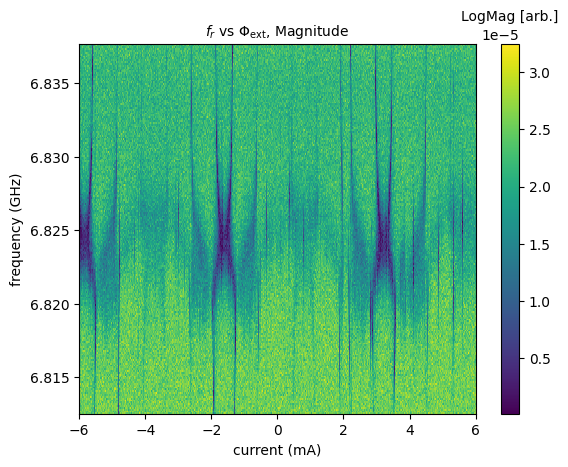

In [493]:
plt.pcolor( current_sweep*1e3,spec_freq/1e9, np.abs(sweep_rspec_results).T)
plt.ylabel('frequency (GHz)')
plt.xlabel('current (mA)')
plt.title(r'$f_r$ vs $\Phi_{\text{ext}}$, Magnitude', size=10)
plt.colorbar().ax.set_title('LogMag [arb.]', size=10)

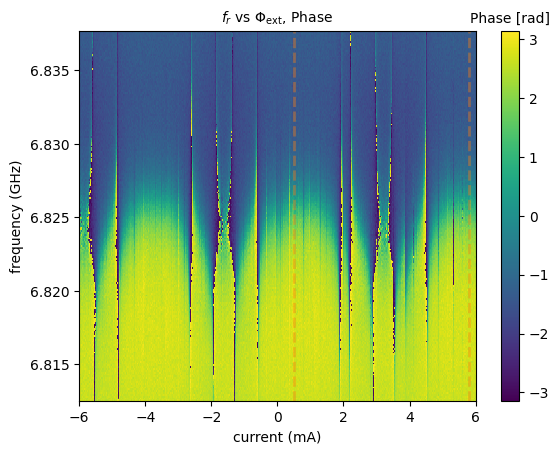

In [500]:
plt.pcolor( current_sweep*1e3,spec_freq/1e9, np.angle(np.exp(1j*electrical_delay*2*np.pi*spec_freq)*sweep_rspec_results).T)
plt.ylabel('frequency (GHz)')
plt.xlabel('current (mA)')
plt.title('phase')
plt.title(r'$f_r$ vs $\Phi_{\text{ext}}$, Phase', size=10)
plt.colorbar().ax.set_title('Phase [rad]', size=10)
plt.axvline(0.5, c='tab:orange', alpha=0.4, lw=2, ls='--')
plt.axvline(5.8, c='tab:orange', alpha=0.4, lw=2, ls='--')
# plt.axhline(6.6624, c='tab:purple', alpha=0.4)

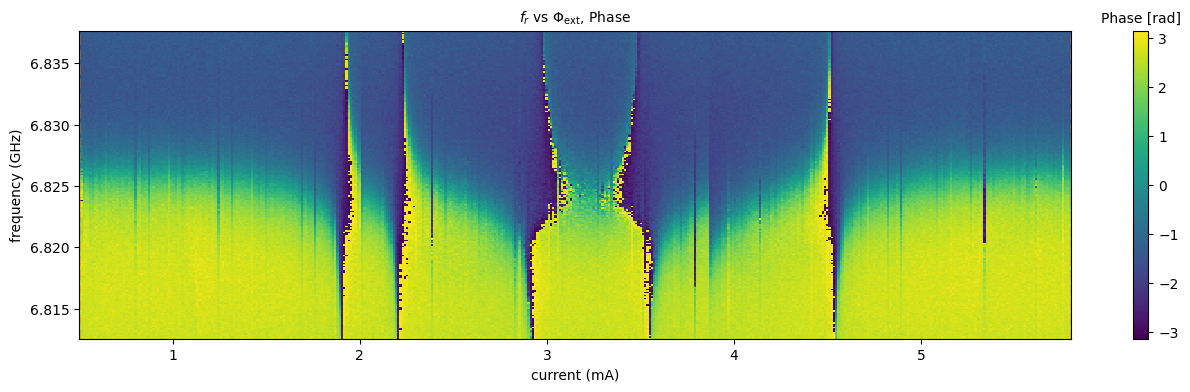

In [505]:
plt.figure(figsize=(16, 4))
plt.pcolor(current_sweep*1e3,spec_freq/1e9, np.angle(np.exp(1j*electrical_delay*2*np.pi*spec_freq)*sweep_rspec_results).T)
plt.xlim(0.5, 5.8)
plt.ylabel('frequency (GHz)')
plt.xlabel('current (mA)')
plt.title('phase')
plt.title(r'$f_r$ vs $\Phi_{\text{ext}}$, Phase', size=10)
plt.colorbar().ax.set_title('Phase [rad]', size=10)
plt.axvline(0.5, c='tab:orange', alpha=0.4, lw=2, ls='--')
plt.axvline(5.8, c='tab:orange', alpha=0.4, lw=2, ls='--')
# plt.axhline(6.6624, c='tab:purple', alpha=0.4)

In [514]:
electrical_delay = 65.001e-9

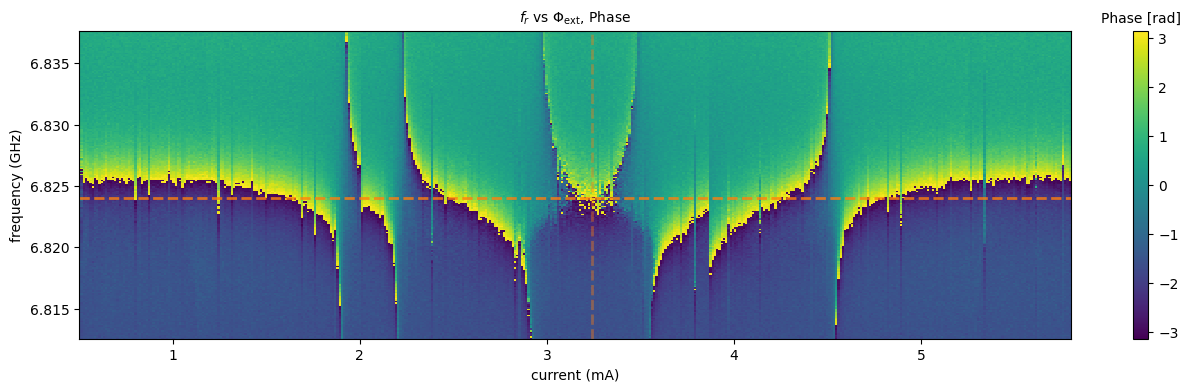

In [538]:
plt.figure(figsize=(16, 4))
plt.pcolor(current_sweep*1e3,spec_freq/1e9, np.angle(np.exp(1j*electrical_delay*2*np.pi*spec_freq)*sweep_rspec_results).T)
plt.xlim(0.5, 5.8)
plt.ylabel('frequency (GHz)')
plt.xlabel('current (mA)')
plt.title('phase')
plt.title(r'$f_r$ vs $\Phi_{\text{ext}}$, Phase', size=10)
plt.colorbar().ax.set_title('Phase [rad]', size=10)
# plt.axvline(0.5, c='tab:orange', alpha=0.4, lw=2, ls='--')
plt.axvline(3.24, c='tab:orange', alpha=0.4, lw=2, ls='--')
plt.axhline(6.824, c='tab:orange', alpha=0.8, lw=2, ls='--')

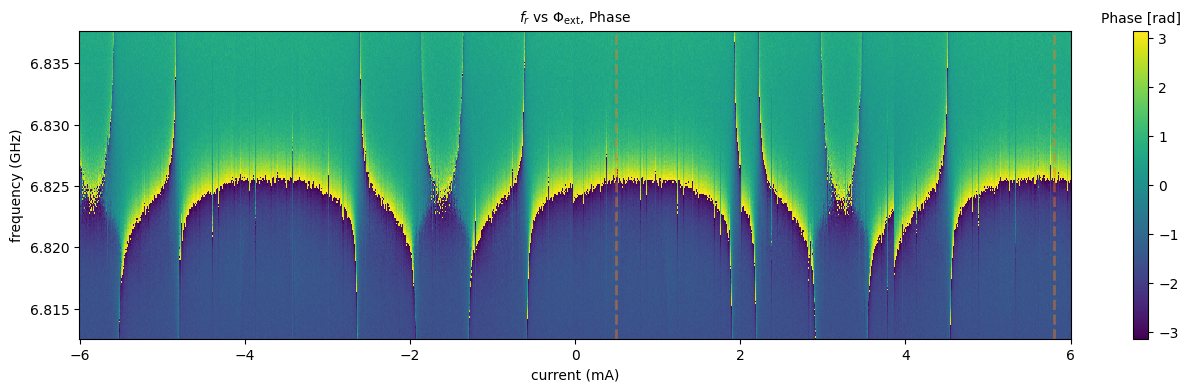

In [517]:
plt.figure(figsize=(16, 4))
plt.pcolor( current_sweep*1e3,spec_freq/1e9, np.angle(np.exp(1j*electrical_delay*2*np.pi*spec_freq)*sweep_rspec_results).T)
plt.ylabel('frequency (GHz)')
plt.xlabel('current (mA)')
plt.title('phase')
plt.title(r'$f_r$ vs $\Phi_{\text{ext}}$, Phase', size=10)
plt.colorbar().ax.set_title('Phase [rad]', size=10)
plt.axvline(0.5, c='tab:orange', alpha=0.4, lw=2, ls='--')
plt.axvline(5.8, c='tab:orange', alpha=0.4, lw=2, ls='--')
# plt.axhline(6.6624, c='tab:purple', alpha=0.4)

In [523]:
np.shape(sweep_rspec_results)

(1001, 201)

In [528]:
plot_data = (np.angle(np.exp(1j*electrical_delay*2*np.pi*spec_freq)*sweep_rspec_results))

In [529]:
plot_data.shape

(1001, 201)

In [527]:
spec_freq.shape

(201,)

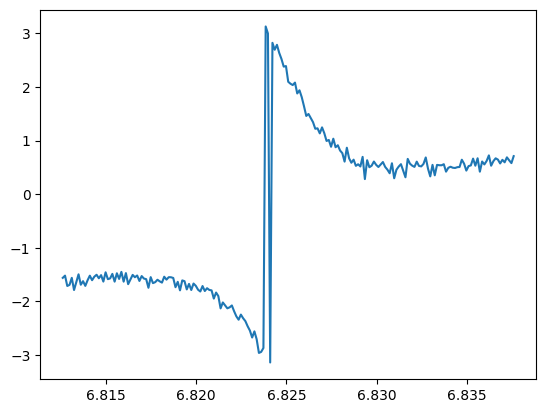

In [531]:
plt.plot(spec_freq/1e9, plot_data[500])

## Two tone (pulsed qubit spectroscopy)

### Setup current source

In [691]:
current_set_point = 3.24e-3
# current_set_point = 1e-3

In [ ]:
from qcodes.instrument_drivers.yokogawa.GS200 import GS200
dc = GS200('yoko', address = 'TCPIP0::192.168.3.193::inst0::INSTR')

In [544]:
dc.off()
dc.output('off')
dc.source_mode('CURR')
dc.ramp_current(0e-3, 1e-6,0)

In [692]:
# turn on current and set to half flux value

dc.output('on')
dc.ramp_current(current_set_point, 0.5e-6, 0)

In [560]:
dc.ramp_current(0, 0.5e-6, 0)

#### 3.5.1 Additional Experimental Parameters

Define the frequency scan and the pulses used in the experiment

In [710]:
measure_q.parameters.readout_range_in = -10

In [739]:
# frequency range of spectroscopy scan - defined +/- expected qubit frequency as defined in qubit parameters
# qspec_range = 500e6
# how many frequency points to measure
qspec_num = 2001

# define number of averages
# used for 2^num_averages, maximum: num_averages = 17
num_averages = 12

In [740]:
2**12

4096

In [741]:
# measure_q.parameters.resonance_frequency_ge = 1e9
# measure_q.parameters.resonance_frequency_ef = 1e9
# device_setup.set_calibration(measure_q.calibration())

In [764]:
### QB spec
# q_freq = 5.35e9
drive_lo_freq = 3e9
measure_q.parameters.drive_lo_frequency = drive_lo_freq
measure_q.parameters.resonance_frequency_ge = drive_lo_freq
measure_q.parameters.resonance_frequency_ef = drive_lo_freq
LF_path = False
start_freq = -500e6
stop_freq = 500e6
measure_q.parameters.user_defined['amplitude_pi'] = 0.99

measure_q.parameters.drive_range = 10
measure_q.parameters.user_defined['reset_length'] = 1e-6
measure_q.parameters.user_defined['pulse_length'] = 2000e-09
measure_q.parameters.readout_resonator_frequency = 6.824e9
# measure_q.parameters.readout_resonator_frequency = 6.825e9

print(measure_q)

Transmon(
│   uid='q0',
│   signals={'drive': '/logical_signal_groups/q0/drive_line', 'measure': '/logical_signal_groups/q0/measure_line', 'acquire': '/logical_signal_groups/q0/acquire_line'},
│   parameters=TransmonParameters(
│   │   resonance_frequency_ge=3000000000.0,
│   │   resonance_frequency_ef=3000000000.0,
│   │   drive_lo_frequency=3000000000.0,
│   │   readout_resonator_frequency=6824000000.0,
│   │   readout_lo_frequency=6500000000.0,
│   │   readout_integration_delay=6e-08,
│   │   drive_range=10,
│   │   readout_range_out=-30,
│   │   readout_range_in=-10,
│   │   flux_offset_voltage=0,
│   │   user_defined={
│   │   │   'amplitude_pi': 0.99,
│   │   │   'pulse_length': 2e-06,
│   │   │   'readout_len': 2e-06,
│   │   │   'readout_amp': 0.04,
│   │   │   'reset_length': 1e-06,
│   │   │   'readout_range_out': -30,
│   │   │   'readout_range_in': -15
│   │   }
│   )
)

In [765]:
res = ((stop_freq - start_freq)/qspec_num)*1e-6
print(f'Drive freq resolution = {res} MHz')

Drive freq resolution = 0.49975012493753124 MHz


In [766]:
device_setup.set_calibration(
    measure_q.calibration()
)

#### 3.5.2 Experiment Definition

The frequency sweep of the drive line can now be done in real time (was: near time in older software releases)

In [767]:
# function that returns a qubit spectroscopy experiment- accepts frequency sweep range as parameter


def qubit_spectroscopy(freq_sweep, drive_pulse, readout_pulse, reset_delay):
    # Create qubit spectroscopy Experiment - uses qubit drive, readout drive and data acquisition lines
    exp_qspec = Experiment(
        uid="Qubit Spectroscopy",
        signals=[
            ExperimentSignal("drive"),
            ExperimentSignal("measure"),
            ExperimentSignal("acquire"),
        ],
    )

    
    
    # inner loop - real-time averaging - QA in integration mode
    with exp_qspec.acquire_loop_rt(
        uid="freq_shots",
        count=2**num_averages,
        acquisition_type=AcquisitionType.INTEGRATION,
    ):
        
        with exp_qspec.sweep(uid="qfreq_sweep", parameter=freq_sweep):
            # qubit drive
            with exp_qspec.section(uid="qubit_excitation"):
                # exp_qspec.play(signal="drive", pulse=drive_pulse)
                exp_qspec.play(signal="drive", pulse=drive_pulse, marker = {"marker1": {"enable": True}})
            with exp_qspec.section(
                uid="readout_section", play_after="qubit_excitation"
            ):
                # play readout pulse on measure line
                exp_qspec.play(signal="measure", pulse=readout_pulse)
                # trigger signal data acquisition
                exp_qspec.acquire(
                    signal="acquire",
                    handle="qb_spec",
                    kernel=readout_pulse,
                )
            with exp_qspec.section(uid="delay"):
                # relax time after readout - for qubit relaxation to groundstate and signal processing
                exp_qspec.delay(signal="measure", time=reset_delay)

    return exp_qspec

In [768]:
freq_sweep_q = create_drive_freq_sweep(measure_q, start_freq, stop_freq, qspec_num)

# experiment signal calibration for qubit, specifically overwriting the frequency to the sweep parameter
exp_calibration_q = Calibration()

if LF_path == True:
    exp_calibration_q["drive"] = SignalCalibration(
        oscillator=Oscillator(
            frequency=freq_sweep_q,
            modulation_type=ModulationType.HARDWARE,
        ),
        port_mode = PortMode.LF
    )
else:
    exp_calibration_q["drive"] = SignalCalibration(
        oscillator=Oscillator(
            frequency=freq_sweep_q,
            modulation_type=ModulationType.HARDWARE,
        ),
    )

In [769]:
freq_sweep_q.start/1e9

-0.5

#### 3.5.3 Run and Evaluate Experiment for Both Qubits

Runs the experiment and evaluates the data returned by the measurement

In [770]:
# define experiment with frequency sweep for qubit 0
drive_pulse = create_drive_spec_pulse(measure_q)

readout_pulse = create_readout_pulse(measure_q)

#update default calibration to qubit settings
device_setup.set_calibration(
    measure_q.calibration()
)

exp_qspec = qubit_spectroscopy(freq_sweep_q, drive_pulse, readout_pulse, reset_delay = measure_q.parameters.user_defined['reset_length'])

# apply calibration and signal map for qubit for this experiment
exp_qspec.set_calibration(exp_calibration_q)
exp_qspec.set_signal_map(signal_map_default(measure_q))

In [771]:
# compile the experiment on the open instrument session
compiled_qspec = session.compile(exp_qspec)

#Path("Pulse_Sheets").mkdir(parents=True, exist_ok=True)
# generate a pulse sheet to inspect experiment before runtime
#show_pulse_sheet("Pulse_Sheets/Qubit_Spectroscopy", compiled_qspec)

# plot_simulation(compiled_qspec, 0, 10e-6)

[2024.07.10 11:20:04.426] INFO    Starting LabOne Q Compiler run...
[2024.07.10 11:20:04.623] INFO    Schedule completed. [0.194 s]
[2024.07.10 11:20:05.996] INFO    Code generation completed for all AWGs. [1.372 s]
[2024.07.10 11:20:05.999] INFO    Completed compilation step 1 of 1. [1.570 s]
[2024.07.10 11:20:06.002] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.07.10 11:20:06.003] INFO      Device            AWG   SeqC LOC   CT entries   Waveforms   Samples  
[2024.07.10 11:20:06.004] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.07.10 11:20:06.006] INFO      device_shfqc        0         10            0           1      8000  
[2024.07.10 11:20:06.007] INFO      device_shfqc_sg     0         22            1           1      8000  
[2024.07.10 11:20:06.008] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.07.10 11:20:06.010] INFO      TOTAL                         32 

In [772]:
# # turn on current and set to half flux value

# dc.output('on')
# dc.ramp_current(current_set_point, 0.5e-6, 0)

In [773]:
# run the experiment on qubit 0
qspec_results = session.run()

timestamp = time.strftime("%Y%m%dT%H%M%S")
Path("Results_Needed").mkdir(parents=True, exist_ok=True)
session.save_results(f"Results_Needed/qspec_results_{timestamp}.json")
print(f"File saved as Results_Needed/qspec_results_{timestamp}.json")

[2024.07.10 11:20:06.029] INFO    Configuring the device setup
[2024.07.10 11:20:06.141] INFO    The device setup is configured
[2024.07.10 11:20:07.230] INFO    Starting near-time execution...
[2024.07.10 11:20:07.717] INFO    Estimated RT execution time: 41.70 s.
[2024.07.10 11:20:49.725] INFO    Finished near-time execution.
File saved as Results_Needed/qspec_results_20240710T112049.json


Text(0.5, 0, 'Frequency (GHz)')

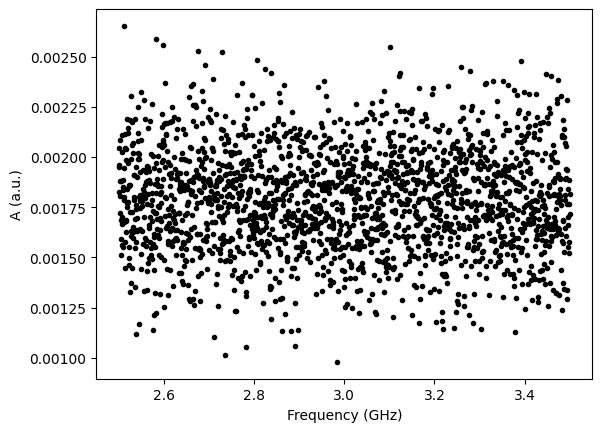

In [774]:
# get measurement data returned by the instruments
qspec_res = qspec_results.get_data("qb_spec")
qspec_freq = qspec_results.get_axis("qb_spec")[0] + measure_q.parameters.drive_lo_frequency

if emulate:
    # create some dummy data if running in emulation mode
    qspec_res = lorentzian(
        qspec_freq,
        5e6,
        measure_q.parameters.resonance_frequency_ge * (0.995 + 0.01 * np.random.rand(1)[0]),
        -2e6,
        1,
    ) + 0.1 * np.random.rand(len(qspec_freq))


# plot measurement data
fig = plt.figure()
plt.plot(qspec_freq / 1e9, abs(qspec_res), ".k")
plt.ylabel("A (a.u.)")
plt.xlabel("Frequency (GHz)")

# plt.axvline(2.1545, linestyle = '--')
# plt.axvline(qspec_freq[np.argmin(abs(qspec_res))]/1e9 , linestyle = '--')
# print('estimated frequency ' + str(qspec_freq[np.argmin(abs(qspec_res))]/1e9) + ' GHz')

# Q1

In [9]:
from qcodes.instrument_drivers.yokogawa.GS200 import GS200
dc = GS200('yoko', address = 'TCPIP0::192.168.3.193::inst0::INSTR')

Connected to: YOKOGAWA GS210 (serial:91N522620, firmware:2.02) in 0.42s


In [10]:
dc.ramp_current(0e-3, 1e-6,0)
dc.off()
dc.output('off')
dc.source_mode('CURR')
dc.ramp_current(0e-3, 1e-6,0)

In [317]:
dc.output('off')
dc.source_mode('CURR')

In [318]:
dc.output('on')
dc.ramp_current(0.1e-3, 0.5e-6,0)
dc.ramp_current(0.0e-3, 0.5e-6,0)

## set current

In [138]:
# dc.ramp_current(1e-3, 0.5e-6,0)
dc.output('on')
dc.ramp_current(0.185e-3, 0.5e-6, 1e-3)

In [139]:
# measure_q.parameters.readout_resonator_frequency = 6.880e9
# measure_q.parameters.readout_range_out = -20
# measure_q.parameters.readout_range_in = -10
measure_q.parameters.user_defined['readout_amp'] = 0.18
# electrical_delay = 65.0e-9

device_setup.set_calibration(
    measure_q.calibration()
)

## Resonator vs flux 

### resonator spectroscopy setup

In [195]:
# frequency range of spectroscopy scan -
# around expected resonator frequency as defined in qubit parameters
start_freq = -10e6
stop_freq = 15e6
num_points = 61

# define number of averages
# used for 2^num_averages, maximum: num_averages = 17
num_averages = 12

readout_pulse = create_readout_pulse(measure_q)

In [196]:
2**12

4096

In [197]:
print(measure_q)

Transmon(
│   uid='q0',
│   signals={'drive': '/logical_signal_groups/q0/drive_line', 'measure': '/logical_signal_groups/q0/measure_line', 'acquire': '/logical_signal_groups/q0/acquire_line'},
│   parameters=TransmonParameters(
│   │   resonance_frequency_ge=1300000000.0,
│   │   resonance_frequency_ef=1300000000.0,
│   │   drive_lo_frequency=1300000000.0,
│   │   readout_resonator_frequency=6881500000.0,
│   │   readout_lo_frequency=6500000000.0,
│   │   readout_integration_delay=6e-08,
│   │   drive_range=10,
│   │   readout_range_out=-20,
│   │   readout_range_in=-10,
│   │   flux_offset_voltage=0,
│   │   user_defined={
│   │   │   'amplitude_pi': 0.99,
│   │   │   'pulse_length': 2e-06,
│   │   │   'readout_len': 2e-06,
│   │   │   'readout_amp': 0.18,
│   │   │   'reset_length': 1e-06
│   │   }
│   )
)

In [198]:
# measure_q.parameters.user_defined['readout_amp'] = 0.1
measure_q.parameters.readout_range_out = -30
measure_q.parameters.readout_range_in = -15
device_setup.set_calibration(
    measure_q.calibration()
)

#### 3.2.2 Experiment Definition

In [199]:
# function that defines a resonator spectroscopy experiment, and takes the frequency sweep as a parameter

def res_spectroscopy_pulsed(freq_sweep, num_averages, readout_pulse):
    # Create resonator spectroscopy experiment - uses only readout drive and signal acquisition
    exp_spec_pulsed = Experiment(
        uid="Resonator Spectroscopy",
        signals=[
            ExperimentSignal("measure"),
            ExperimentSignal("acquire"),
        ],
    )

    ## define experimental sequence
    # outer loop - vary drive frequency

    # inner loop - average multiple measurements for each frequency - measurement in spectroscopy mode
    with exp_spec_pulsed.acquire_loop_rt(
        uid="shots",
        count=2**num_averages,
        acquisition_type=AcquisitionType.SPECTROSCOPY,
        averaging_mode=AveragingMode.SEQUENTIAL,
    ):
        with exp_spec_pulsed.sweep(
            uid="res_freq",
            parameter=freq_sweep,
            chunk_count=1,
        ):
            # readout pulse and data acquisition
            with exp_spec_pulsed.section(uid="spectroscopy"):
                # play resonator excitation pulse
                exp_spec_pulsed.play(signal="measure", pulse=readout_pulse)
                # resonator signal readout
                exp_spec_pulsed.acquire(
                    signal="acquire", handle="res_spec_pulsed", length=readout_pulse.length
                )
            with exp_spec_pulsed.section(uid="delay", length=10e-6):
                # holdoff time after signal acquisition - minimum 1us required for data processing on UHFQA
                exp_spec_pulsed.reserve(signal="measure")

    return exp_spec_pulsed

#### 3.2.3 Apply Experiment Parameters and Compile

In [200]:
# measure_q.parameters.readout_range_out = 5

# # apply calibration to device setup
device_setup.set_calibration(
    measure_q.calibration()
)

In [201]:
# create freq sweep
freq_sweep = create_readout_freq_sweep(measure_q, start_freq, stop_freq, num_points)

# define the experiment with the frequency sweep relevant for qubit
exp_spec_pulsed = res_spectroscopy_pulsed(freq_sweep, num_averages, readout_pulse)

# set signal calibration and signal map for experiment to qubit
exp_spec_pulsed.set_calibration(res_spec_calib(freq_sweep))
exp_spec_pulsed.set_signal_map(res_spec_map(measure_q))

In [202]:
# compile the experiment on the open instrument session
compiled_spec_pulsed = session.compile(exp_spec_pulsed)

Path("Pulse_Sheets").mkdir(parents=True, exist_ok=True)

# generate a pulse sheet to inspect experiment before runtime
show_pulse_sheet("Pulse_Sheets/Pulsed_Spectroscopy", compiled_spec_pulsed)

[2024.07.11 11:04:53.663] INFO    Starting LabOne Q Compiler run...
[2024.07.11 11:04:53.672] INFO    Schedule completed. [0.007 s]
[2024.07.11 11:04:53.700] INFO    Code generation completed for all AWGs. [0.026 s]
[2024.07.11 11:04:53.702] INFO    Completed compilation step 1 of 1. [0.037 s]
[2024.07.11 11:04:53.709] INFO     ────────────────────────────────────────────────────────────────── 
[2024.07.11 11:04:53.712] INFO      Device         AWG   SeqC LOC   CT entries   Waveforms   Samples  
[2024.07.11 11:04:53.715] INFO     ────────────────────────────────────────────────────────────────── 
[2024.07.11 11:04:53.717] INFO      device_shfqc     0         23            0           1      8000  
[2024.07.11 11:04:53.719] INFO     ────────────────────────────────────────────────────────────────── 
[2024.07.11 11:04:53.722] INFO      TOTAL                      23            0                  8000  
[2024.07.11 11:04:53.725] INFO     ────────────────────────────────────────────────────

Z:\projects\2024-fluxonium\measurement\coupler_20240702\LabOneQ\Pulse_Sheets\Pulsed_Spectroscopy_2024-07-11-11-04-53.html

#### 3.2.4 Run and Evaluate Experiment

In [203]:
# run the experiment on the open instrument session
spec_pulsed_results = session.run()

# save the data
timestamp = time.strftime("%Y%m%dT%H%M%S")
Path("Results_Needed").mkdir(parents=True, exist_ok=True)
session.save_results(f"Results_Needed/spec_pulsed_results_{timestamp}.json")
print(f"File saved as Results_Needed/spec_pulsed_results_{timestamp}.json")

[2024.07.11 11:05:01.611] INFO    Configuring the device setup
[2024.07.11 11:05:01.724] INFO    The device setup is configured
[2024.07.11 11:05:02.542] INFO    Starting near-time execution...
[2024.07.11 11:05:06.289] INFO    Finished near-time execution.
File saved as Results_Needed/spec_pulsed_results_20240711T110506.json


In [204]:
electrical_delay = 65.3e-9

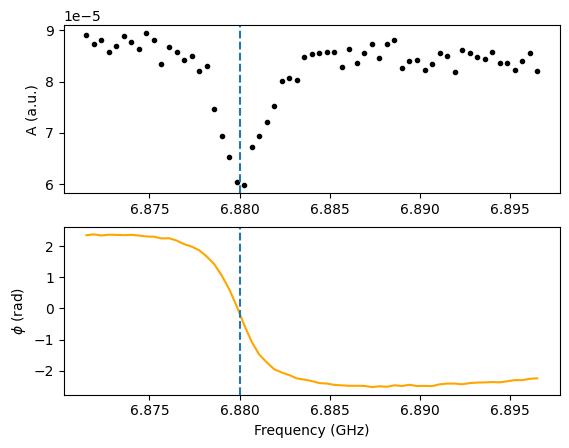

In [205]:
# get the measurement data returned by the instruments from the QCCS session
spec_res = spec_pulsed_results.get_data("res_spec_pulsed")
# define the frequency axis from the qubit parameters
spec_freq = (
    measure_q.parameters.readout_lo_frequency + spec_pulsed_results.get_axis("res_spec_pulsed")[0]
)

if emulate:
    # create some dummy data if running in emulation mode
    spec_res = lorentzian(
        spec_freq,
        10e6,
        measure_q.parameters.readout_resonator_frequency * (0.995 + 0.01 * np.random.rand(1)[0]),
        -2e6,
        1,
    ) + 0.1 * np.random.rand(len(spec_freq))

# plot the measurement data
fig, [ax1, ax2] = plt.subplots(2, 1)
ax1.plot(spec_freq / 1e9, abs(spec_res), ".k")
ax2.plot(spec_freq / 1e9, np.angle(np.exp(1j*electrical_delay*2*np.pi*spec_freq)*spec_res), "orange")
ax1.set_ylabel("A (a.u.)")
ax2.set_ylabel("$\\phi$ (rad)")
ax2.set_xlabel("Frequency (GHz)")
# ax2.axvline(spec_freq[np.argmin(np.angle(np.exp(1j*electrical_delay*2*np.pi*spec_freq)*spec_res))]/1e9)
# spec_freq[np.argmin(abs(spec_res))]/1e9

test_f = 6.880
ax1.axvline(test_f, ls='--')
ax2.axvline(test_f, ls='--')

### f_r vs phi ext

In [ ]:
plot = False  # plot individual resonator spectroscopy
dc.current_range(0.01)

start_curr = -6e-3
stop_curr = 6e-3
# stop_curr = 3e-3
current_sweep = np.linspace(start_curr,stop_curr, 1001)

dc.ramp_current(0e-3, 0.5e-6, 0)

dc.output('off')
dc.source_mode('CURR')

dc.output('on')
sweep_rspec_results = []
for i, current in enumerate(current_sweep):
    print('step ' + str(i))
    print(f'current: {current}')
    
    dc.ramp_current(current, 0.5e-6, 0)

    # debugging
    # dc.ramp_current(0e-3, 1e-6,0)
    # dc.output('off')
    # sys.exit()
    # time.sleep(0.5)
    
    # run the experiment on qubit 0
    rspec_results = session.run()

    # save the data
    timestamp = time.strftime("%Y%m%dT%H%M%S")
    Path("Results_Needed").mkdir(parents=True, exist_ok=True)
    session.save_results(f"Results_Needed/spec_pulsed_results_{timestamp}.json")
    print(f"File saved as Results_Needed/spec_pulsed_results_{timestamp}.json")
    
    # get the measurement data returned by the instruments from the QCCS session
    spec_res = rspec_results.get_data("res_spec_pulsed")
    # define the frequency axis from the qubit parameters
    spec_freq = (
        measure_q.parameters.readout_lo_frequency + spec_pulsed_results.get_axis("res_spec_pulsed")[0]
    )
    sweep_rspec_results.append(spec_res)

    # plot the measurement data
    if plot:
        plt.figure()
        fig, [ax1, ax2] = plt.subplots(2, 1)
        ax1.plot(spec_freq / 1e9, abs(spec_res), ".k")
        ax2.plot(spec_freq / 1e9, np.angle(np.exp(1j*electrical_delay*2*np.pi*spec_freq)*spec_res), "orange")
        ax1.set_ylabel("A (a.u.)")
        ax2.set_ylabel("$\\phi$ (rad)")
        ax2.set_xlabel("Frequency (GHz)")
        ax2.axvline(spec_freq[np.argmin(abs(spec_res))]/1e9)

dc.ramp_current(0,0.5e-6,0)
dc.output('off')

In [ ]:
plt.pcolor( current_sweep*1e3,spec_freq/1e9, np.abs(sweep_rspec_results).T)
plt.ylabel('frequency (GHz)')
plt.xlabel('current (mA)')
plt.title(r'$f_r$ vs $\Phi_{\text{ext}}$, Magnitude', size=10)
plt.colorbar().ax.set_title('LogMag [arb.]', size=10)

In [ ]:
plt.pcolor( current_sweep*1e3,spec_freq/1e9, np.angle(np.exp(1j*electrical_delay*2*np.pi*spec_freq)*sweep_rspec_results).T)
plt.ylabel('frequency (GHz)')
plt.xlabel('current (mA)')
plt.title('phase')
plt.title(r'$f_r$ vs $\Phi_{\text{ext}}$, Phase', size=10)
plt.colorbar().ax.set_title('Phase [rad]', size=10)
plt.axvline(0.5, c='tab:orange', alpha=0.4, lw=2, ls='--')
plt.axvline(5.8, c='tab:orange', alpha=0.4, lw=2, ls='--')
# plt.axhline(6.6624, c='tab:purple', alpha=0.4)

In [ ]:
plt.figure(figsize=(16, 4))
plt.pcolor(current_sweep*1e3,spec_freq/1e9, np.angle(np.exp(1j*electrical_delay*2*np.pi*spec_freq)*sweep_rspec_results).T)
plt.xlim(0.5, 5.8)
plt.ylabel('frequency (GHz)')
plt.xlabel('current (mA)')
plt.title('phase')
plt.title(r'$f_r$ vs $\Phi_{\text{ext}}$, Phase', size=10)
plt.colorbar().ax.set_title('Phase [rad]', size=10)
plt.axvline(0.5, c='tab:orange', alpha=0.4, lw=2, ls='--')
plt.axvline(5.8, c='tab:orange', alpha=0.4, lw=2, ls='--')
# plt.axhline(6.6624, c='tab:purple', alpha=0.4)

In [ ]:
electrical_delay = 65.001e-9

In [ ]:
plt.figure(figsize=(16, 4))
plt.pcolor(current_sweep*1e3,spec_freq/1e9, np.angle(np.exp(1j*electrical_delay*2*np.pi*spec_freq)*sweep_rspec_results).T)
plt.xlim(0.5, 5.8)
plt.ylabel('frequency (GHz)')
plt.xlabel('current (mA)')
plt.title('phase')
plt.title(r'$f_r$ vs $\Phi_{\text{ext}}$, Phase', size=10)
plt.colorbar().ax.set_title('Phase [rad]', size=10)
# plt.axvline(0.5, c='tab:orange', alpha=0.4, lw=2, ls='--')
plt.axvline(3.24, c='tab:orange', alpha=0.4, lw=2, ls='--')
plt.axhline(6.824, c='tab:orange', alpha=0.8, lw=2, ls='--')

In [ ]:
plt.figure(figsize=(16, 4))
plt.pcolor( current_sweep*1e3,spec_freq/1e9, np.angle(np.exp(1j*electrical_delay*2*np.pi*spec_freq)*sweep_rspec_results).T)
plt.ylabel('frequency (GHz)')
plt.xlabel('current (mA)')
plt.title('phase')
plt.title(r'$f_r$ vs $\Phi_{\text{ext}}$, Phase', size=10)
plt.colorbar().ax.set_title('Phase [rad]', size=10)
plt.axvline(0.5, c='tab:orange', alpha=0.4, lw=2, ls='--')
plt.axvline(5.8, c='tab:orange', alpha=0.4, lw=2, ls='--')
# plt.axhline(6.6624, c='tab:purple', alpha=0.4)

In [ ]:
np.shape(sweep_rspec_results)

In [ ]:
plot_data = (np.angle(np.exp(1j*electrical_delay*2*np.pi*spec_freq)*sweep_rspec_results))

In [ ]:
plot_data.shape

In [ ]:
spec_freq.shape

In [ ]:
plt.plot(spec_freq/1e9, plot_data[500])

## Two tone (pulsed qubit spectroscopy)

### Setup current source

In [44]:
current_set_point = 0.173e-3

In [45]:
# dc.output('on')
dc.ramp_current(current_set_point, 0.5e-6, 0)

#### 3.5.1 Additional Experimental Parameters

Define the frequency scan and the pulses used in the experiment

In [179]:
# frequency range of spectroscopy scan - defined +/- expected qubit frequency as defined in qubit parameters
# qspec_range = 500e6
# how many frequency points to measure
qspec_num = 10001
# qspec_num = 501
# qspec_num = 1501

# define number of averages
# used for 2^num_averages, maximum: num_averages = 17
num_averages = 13

In [180]:
2**13

8192

In [181]:
measure_q.parameters.user_defined['readout_amp'] = 0.18
measure_q.parameters.readout_range_out = -20
measure_q.parameters.readout_range_in = -10
device_setup.set_calibration(
    measure_q.calibration()
)

In [182]:
### QB spec
drive_lo_freq = 1.3e9
# drive_lo_freq = 2.4e9
measure_q.parameters.drive_lo_frequency = drive_lo_freq
measure_q.parameters.resonance_frequency_ge = drive_lo_freq
measure_q.parameters.resonance_frequency_ef = drive_lo_freq
LF_path = False

# start_freq = -250e6
# stop_freq = -240e6

# start_freq = -280e6
# stop_freq = -210e6

start_freq = -500e6
stop_freq = 500e6
measure_q.parameters.user_defined['amplitude_pi'] = 0.99

measure_q.parameters.drive_range = 10
measure_q.parameters.user_defined['reset_length'] = 1e-6
measure_q.parameters.user_defined['pulse_length'] = 2000e-09
# measure_q.parameters.readout_resonator_frequency = 6.8825e9
# measure_q.parameters.readout_resonator_frequency = 6.880e9
measure_q.parameters.readout_resonator_frequency = 6.8815e9

print(measure_q)

Transmon(
│   uid='q0',
│   signals={'drive': '/logical_signal_groups/q0/drive_line', 'measure': '/logical_signal_groups/q0/measure_line', 'acquire': '/logical_signal_groups/q0/acquire_line'},
│   parameters=TransmonParameters(
│   │   resonance_frequency_ge=1300000000.0,
│   │   resonance_frequency_ef=1300000000.0,
│   │   drive_lo_frequency=1300000000.0,
│   │   readout_resonator_frequency=6881500000.0,
│   │   readout_lo_frequency=6500000000.0,
│   │   readout_integration_delay=6e-08,
│   │   drive_range=10,
│   │   readout_range_out=-20,
│   │   readout_range_in=-10,
│   │   flux_offset_voltage=0,
│   │   user_defined={
│   │   │   'amplitude_pi': 0.99,
│   │   │   'pulse_length': 2e-06,
│   │   │   'readout_len': 2e-06,
│   │   │   'readout_amp': 0.18,
│   │   │   'reset_length': 1e-06
│   │   }
│   )
)

In [94]:
res = ((stop_freq - start_freq)/qspec_num)*1e-6
print(f'Drive freq resolution = {res} MHz')

Drive freq resolution = 0.09999000099989999 MHz


In [95]:
device_setup.set_calibration(
    measure_q.calibration()
)

#### 3.5.2 Experiment Definition

The frequency sweep of the drive line can now be done in real time (was: near time in older software releases)

In [96]:
# function that returns a qubit spectroscopy experiment- accepts frequency sweep range as parameter


def qubit_spectroscopy(freq_sweep, drive_pulse, readout_pulse, reset_delay):
    # Create qubit spectroscopy Experiment - uses qubit drive, readout drive and data acquisition lines
    exp_qspec = Experiment(
        uid="Qubit Spectroscopy",
        signals=[
            ExperimentSignal("drive"),
            ExperimentSignal("measure"),
            ExperimentSignal("acquire"),
        ],
    )

    
    
    # inner loop - real-time averaging - QA in integration mode
    with exp_qspec.acquire_loop_rt(
        uid="freq_shots",
        count=2**num_averages,
        acquisition_type=AcquisitionType.INTEGRATION,
    ):
        
        with exp_qspec.sweep(uid="qfreq_sweep", parameter=freq_sweep):
            # qubit drive
            with exp_qspec.section(uid="qubit_excitation"):
                # exp_qspec.play(signal="drive", pulse=drive_pulse)
                exp_qspec.play(signal="drive", pulse=drive_pulse, marker = {"marker1": {"enable": True}})
            with exp_qspec.section(
                uid="readout_section", play_after="qubit_excitation"
            ):
                # play readout pulse on measure line
                exp_qspec.play(signal="measure", pulse=readout_pulse)
                # trigger signal data acquisition
                exp_qspec.acquire(
                    signal="acquire",
                    handle="qb_spec",
                    kernel=readout_pulse,
                )
            with exp_qspec.section(uid="delay"):
                # relax time after readout - for qubit relaxation to groundstate and signal processing
                exp_qspec.delay(signal="measure", time=reset_delay)

    return exp_qspec

In [97]:
freq_sweep_q = create_drive_freq_sweep(measure_q, start_freq, stop_freq, qspec_num)

# experiment signal calibration for qubit, specifically overwriting the frequency to the sweep parameter
exp_calibration_q = Calibration()

if LF_path == True:
    exp_calibration_q["drive"] = SignalCalibration(
        oscillator=Oscillator(
            frequency=freq_sweep_q,
            modulation_type=ModulationType.HARDWARE,
        ),
        port_mode = PortMode.LF
    )
else:
    exp_calibration_q["drive"] = SignalCalibration(
        oscillator=Oscillator(
            frequency=freq_sweep_q,
            modulation_type=ModulationType.HARDWARE,
        ),
    )

In [98]:
freq_sweep_q.start/1e9

-0.5

#### 3.5.3 Run and Evaluate Experiment for Both Qubits

Runs the experiment and evaluates the data returned by the measurement

In [99]:
# define experiment with frequency sweep for qubit 0
drive_pulse = create_drive_spec_pulse(measure_q)

readout_pulse = create_readout_pulse(measure_q)

#update default calibration to qubit settings
device_setup.set_calibration(
    measure_q.calibration()
)

exp_qspec = qubit_spectroscopy(freq_sweep_q, drive_pulse, readout_pulse, reset_delay = measure_q.parameters.user_defined['reset_length'])

# apply calibration and signal map for qubit for this experiment
exp_qspec.set_calibration(exp_calibration_q)
exp_qspec.set_signal_map(signal_map_default(measure_q))

In [100]:
# compile the experiment on the open instrument session
compiled_qspec = session.compile(exp_qspec)

#Path("Pulse_Sheets").mkdir(parents=True, exist_ok=True)
# generate a pulse sheet to inspect experiment before runtime
#show_pulse_sheet("Pulse_Sheets/Qubit_Spectroscopy", compiled_qspec)

# plot_simulation(compiled_qspec, 0, 10e-6)

[2024.07.10 18:30:12.631] INFO    Starting LabOne Q Compiler run...
[2024.07.10 18:30:13.989] INFO    Schedule completed. [1.361 s]
[2024.07.10 18:30:22.955] INFO    Code generation completed for all AWGs. [8.959 s]
[2024.07.10 18:30:22.957] INFO    Completed compilation step 1 of 1. [10.324 s]
[2024.07.10 18:30:22.960] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.07.10 18:30:22.961] INFO      Device            AWG   SeqC LOC   CT entries   Waveforms   Samples  
[2024.07.10 18:30:22.963] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.07.10 18:30:22.964] INFO      device_shfqc        0         10            0           1      8000  
[2024.07.10 18:30:22.965] INFO      device_shfqc_sg     0         22            1           1      8000  
[2024.07.10 18:30:22.966] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.07.10 18:30:22.968] INFO      TOTAL                         32

In [101]:
# # turn on current and set to half flux value

# dc.output('on')
# dc.ramp_current(current_set_point, 0.5e-6, 0)

In [74]:
# run the experiment on qubit 0
qspec_results = session.run()

timestamp = time.strftime("%Y%m%dT%H%M%S")
Path("Results_Needed").mkdir(parents=True, exist_ok=True)
session.save_results(f"Results_Needed/qspec_results_{timestamp}.json")
print(f"File saved as Results_Needed/qspec_results_{timestamp}.json")

[2024.07.10 18:18:38.366] INFO    Configuring the device setup
[2024.07.10 18:18:38.476] INFO    The device setup is configured
[2024.07.10 18:18:39.645] INFO    Starting near-time execution...
[2024.07.10 18:18:40.172] INFO    Estimated RT execution time: 416.85 s.
[2024.07.10 18:25:37.372] INFO    Finished near-time execution.
File saved as Results_Needed/qspec_results_20240710T182537.json


Text(0.5, 0, 'Frequency (GHz)')

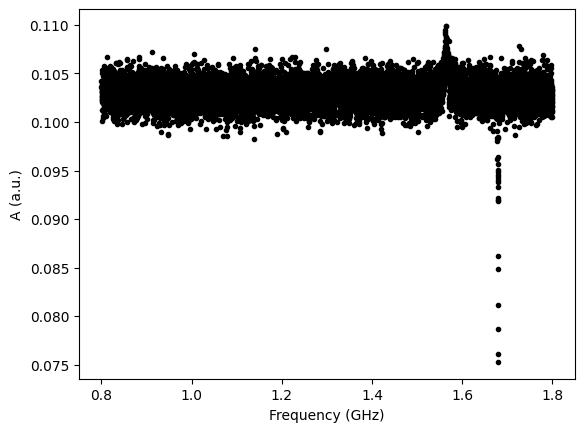

In [75]:
# get measurement data returned by the instruments
qspec_res = qspec_results.get_data("qb_spec")
qspec_freq = qspec_results.get_axis("qb_spec")[0] + measure_q.parameters.drive_lo_frequency

if emulate:
    # create some dummy data if running in emulation mode
    qspec_res = lorentzian(
        qspec_freq,
        5e6,
        measure_q.parameters.resonance_frequency_ge * (0.995 + 0.01 * np.random.rand(1)[0]),
        -2e6,
        1,
    ) + 0.1 * np.random.rand(len(qspec_freq))


# plot measurement data
fig = plt.figure()
plt.plot(qspec_freq / 1e9, abs(qspec_res), ".k")
plt.ylabel("A (a.u.)")
plt.xlabel("Frequency (GHz)")

# plt.axvline(1.7551, linestyle = '--', alpha=0.5)
# plt.axvline(1.731, linestyle = '--', alpha=0.5, color='tab:orange')
# plt.axvline(qspec_freq[np.argmin(abs(qspec_res))]/1e9 , linestyle = '--')
# print('estimated frequency ' + str(qspec_freq[np.argmin(abs(qspec_res))]/1e9) + ' GHz')

In [60]:
start = 1.75
stop=1.76
2 - np.array((start, stop))

array([0.25, 0.24])

# Two Tone vs Flux

In [102]:
plot = False

dc.current_range(0.01)
start = 0.16e-3
stop = 0.19e-3

current_sweep = np.linspace(start, stop, 71)

# dc.ramp_current(0, 1e-5, 0)
dc.output('on')
sweep_qspec_results = []
for current in current_sweep:
    dc.ramp_current(current, 0.5e-6, 1e-3)
    time.sleep(0.5)
    # run the experiment on qubit 0
    qspec_results = session.run()

    timestamp = time.strftime("%Y%m%dT%H%M%S")
    Path("Results_Needed").mkdir(parents=True, exist_ok=True)
    session.save_results(f"Results_Needed/qspec_results_{timestamp}.json")
    print(f"File saved as Results_Needed/qspec_results_{timestamp}.json")
    
    # get measurement data returned by the instruments
    qspec_res = qspec_results.get_data("qb_spec")
    qspec_freq = qspec_results.get_axis("qb_spec")[0] + measure_q.parameters.drive_lo_frequency  # making frequency axis. Add RF frequency to LO
    sweep_qspec_results.append(qspec_res)

    # plot measurement data
    if plot:
        fig = plt.figure()
        plt.plot(qspec_freq / 1e9, abs(qspec_res), ".k")
        plt.ylabel("A (a.u.)")
        plt.xlabel("Frequency (GHz)")

dc.ramp_current(0, 0.5e-6, 1e-3)

[2024.07.10 18:30:39.578] INFO    Configuring the device setup
[2024.07.10 18:30:39.686] INFO    The device setup is configured
[2024.07.10 18:30:40.758] INFO    Starting near-time execution...
[2024.07.10 18:30:41.342] INFO    Estimated RT execution time: 416.85 s.
[2024.07.10 18:37:38.559] INFO    Finished near-time execution.
File saved as Results_Needed/qspec_results_20240710T183738.json
[2024.07.10 18:37:40.518] INFO    Starting near-time execution...
[2024.07.10 18:37:41.091] INFO    Estimated RT execution time: 416.85 s.
[2024.07.10 18:44:38.259] INFO    Finished near-time execution.
File saved as Results_Needed/qspec_results_20240710T184438.json
[2024.07.10 18:44:40.387] INFO    Starting near-time execution...
[2024.07.10 18:44:40.852] INFO    Estimated RT execution time: 416.85 s.
[2024.07.10 18:51:38.053] INFO    Finished near-time execution.
File saved as Results_Needed/qspec_results_20240710T185138.json
[2024.07.10 18:51:39.895] INFO    Starting near-time execution...
[2024

In [164]:
import pickle

save = {'current_sweep': current_sweep,
        'qspec_freq': qspec_freq,
        'sweep_qspec_results': sweep_qspec_results,
       }

with open('local-data/two-tone-overnight_20240710.pickle', 'wb') as handle:
    pickle.dump(save, handle, protocol=pickle.HIGHEST_PROTOCOL)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [165]:
with open('local-data/two-tone-overnight_20240710.pickle', 'rb') as handle:
    b = pickle.load(handle)

In [166]:
b.keys()

dict_keys(['current_sweep', 'qspec_freq', 'sweep_qspec_results'])

In [167]:
b['current_sweep'].shape

(71,)

Text(0.5, 1.0, 'mag')

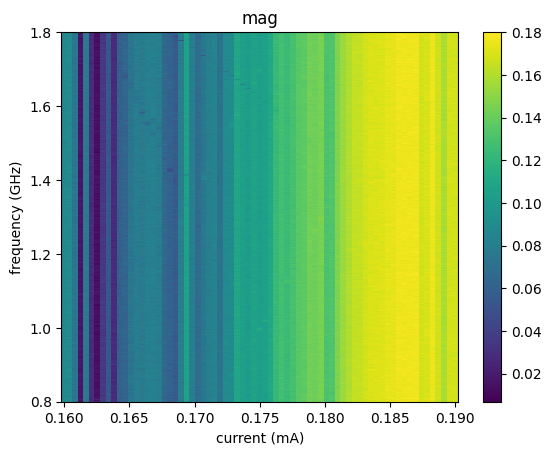

In [103]:
plt.pcolor( current_sweep*1e3,qspec_freq/1e9, np.abs(sweep_qspec_results).T)
plt.ylabel('frequency (GHz)')
plt.xlabel('current (mA)')
plt.colorbar()
plt.title('mag')
# plt.ylim(7.19, 7.215)
# plt.clim(-0.0014, 0.0016)
# plt.axvline(6.2)
# current_sweep[8]*1e3

Text(0.5, 1.0, 'phase')

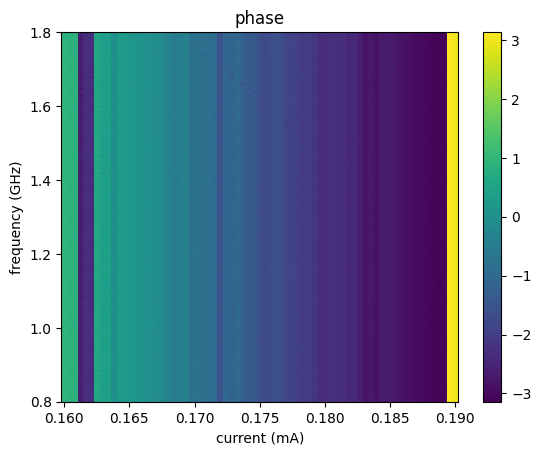

In [108]:
plt.pcolor( current_sweep*1e3,qspec_freq/1e9, np.angle(sweep_qspec_results).T)
plt.ylabel('frequency (GHz)')
plt.xlabel('current (mA)')
plt.colorbar()
plt.title('phase')
# plt.ylim(7.19, 7.215)
# plt.clim(-0.0014, 0.0016)
# plt.axvline(-5.9)
# current_sweep[8]*1e3

In [110]:
np.shape(sweep_qspec_results)

(71, 10001)

In [131]:
from copy import deepcopy

In [133]:
norm = deepcopy(sweep_qspec_results)
for i, dat in enumerate(sweep_qspec_results):
    norm[i] = dat - np.median(dat)

Text(0.5, 1.0, 'mag')

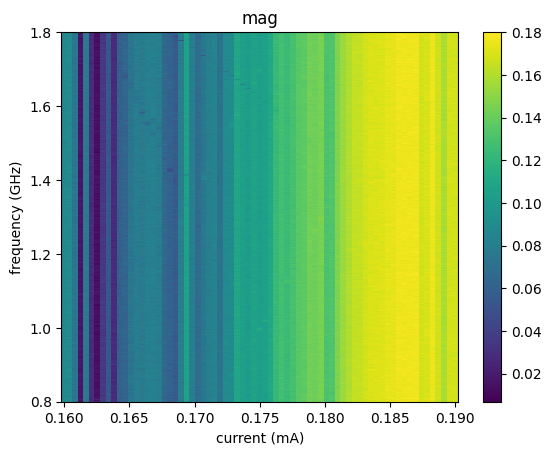

In [135]:
plt.pcolor( current_sweep*1e3,qspec_freq/1e9, np.abs(sweep_qspec_results).T)
plt.ylabel('frequency (GHz)')
plt.xlabel('current (mA)')
plt.colorbar()
plt.title('mag')
# plt.ylim(7.19, 7.215)
# plt.clim(-0.0014, 0.0016)
# plt.axvline(6.2)
# current_sweep[8]*1e3

Text(0.5, 1.0, 'phase')

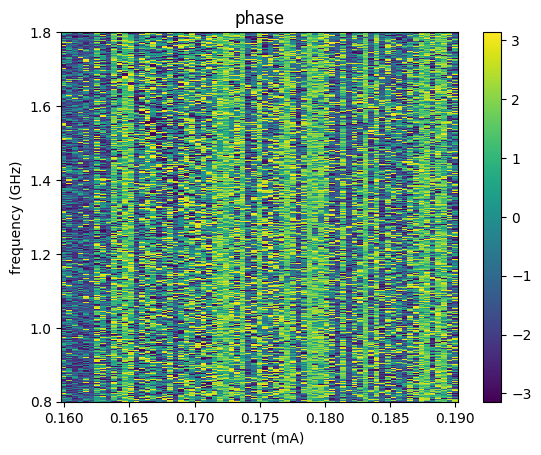

In [137]:
plt.pcolor( current_sweep*1e3,qspec_freq/1e9, np.angle(norm).T)
plt.ylabel('frequency (GHz)')
plt.xlabel('current (mA)')
plt.colorbar()
plt.title('phase')
# plt.ylim(7.19, 7.215)
# plt.clim(-0.0014, 0.0016)
# plt.axvline(-5.9)
# current_sweep[8]*1e3